# **Twitter Sentiment Classification Project**

- [1. Introduction](#1-introduction)
  - [Recurrent Neural Networks](#recurrent-neural-networks)
  - [`Naive Bayes` as a Baseline](#naive-bayes-as-a-baseline)
  - [High Level Steps](#high-level-steps)
- [2. Dataset Loading and Analysis](#2-dataset-loading-and-analysis)
- [3. Preprocessing and Vectorization](#3-preprocess-vectorization)
  - [`TextVectorizationLayer` and Trainable Embedding](#textvec-trainable-emb)
  - [`Tokenizer` and `GloVe` Embedding](#tokenizer-glove)
- [4. Naive Bayes for text classification](#naive-bayes-for-text-classification)
- [5. A Bidirectional LSTM based Model](#bidirectional-model)
  - [2 Bidirectional LSTM layers](#2-bidirectional-lstm-layers)
  - [Pooling](#pooling)
  - [Dense Layers](#dense-layers)
  - [Dropout Layers](#dropout-layers)
  - [Tuning Wrapper](#tuning-wrapper)
- [6. Conclusions](#conclusions)
- [7. Simple Test with our own Tweets](#simple-test)

---

## **1. Introduction**

In this project, we tackle the **binary classification** of **Twitter messages** into **positive** and **negative** categories. We are provided with a dataset containing labeled Tweets that we can leverage for our models.

Our approach focuses on a more detailed exploration of a single model family rather than broadly comparing multiple families, which could lead to overly generic solutions. By conducting a series of experiments, we aim to dig deeper into the specific characteristics of the chosen model family. This approach allows us to experiment with the architecture in a more targeted way.

However, to ensure a robust evaluation and properly assess trade-offs, we will also develop a simple and efficient baseline model for a performance comparison. This baseline is intentionally designed to be straightforward and resource-efficient, without exploring multiple configurations, as its sole purpose is to serve as a point of reference. The primary goal for our final model is to surpass the baseline in performance while maintaining a balanced trade-off between accuracy and computational efficiency.

### **Naive Bayes as a Baseline**

Naive Bayes is used as a baseline due to its simplicity, efficiency, and effectiveness for text classification tasks. It provides quick results with minimal computational resources, making it an ideal reference point to compare more complex models. Its probabilistic nature also handles sparse data well, which is common in text-based datasets like tweets.

### **Recurrent Neural Networks**

We chose to focus on experimenting with Recurrent Neural Networks (RNNs) for the actual model construction. RNNs are particularly well-suited for processing sequential data, as they maintain a hidden state that captures the influence of previous input sequences. Tweets, being short and concise, often require understanding the flow of sentiment within a limited context.

Although Transformers are the state-of-the-art for many NLP tasks, we specifically opted not to use them here. Transformers are optimized for modeling long-range dependencies and contextual relationships across entire documents. While highly effective, their self-attention mechanism can be unnecessary for short texts like tweets. Additionally, Transformers are more computationally intensive. For a simpler binary classification task, this added complexity can result in inefficiencies without a proportional gain in performance.

Our development approach prioritized reusability by designing the code in a modular way, allowing functions to be easily reused across different tasks. This modular structure also ensures that the model can be easily adapted to other sentiment analysis binary classification tasks, simply by plugging in task-specific functions (e.g. message preprocessing) that can be tailored to suit the particular task (in our case, Twitter messages).

### **High Level Steps**

From high-level, the project will follow these steps:

1. Load the dataset and perform a visual analysis.
2. Employ two different preprocessing strategies, along with various vectorization and embedding techniques.
3. Develop a Naive Bayes based pipeline as a simple and efficient starting point for a trade-off analysis and performance comparison with the final RNN-based model.
4. Build and evaluate a bidirectional LSTM-based model with different configurations.
5. Informally test the built model on our own tweets.

---


In [132]:
## Dependencies and reusable functions for the notebook

# General dependencies
import os
import logging
import warnings
import math
import re
# Data processing dependencies
import numpy as np
import pandas as pd
# ML dependencies
import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing, callbacks
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import naive_bayes, pipeline
import keras_tuner as kt
# Visualization dependencies
from rich.table import Table
from rich.console import Console
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
%matplotlib inline

def unbatch_ds(batched_ds, decode=False, np_array=False):
    X_data = []
    y_data = []
    for x, y in batched_ds.unbatch():
        if decode:
            X_data.append(x.numpy().decode())
        else:
            X_data.append(x.numpy())    
        y_data.append(y.numpy())

    if np_array:
        X_data = np.array(X_data)
    else:
        X_data = tf.convert_to_tensor(X_data)
    
    y_data = np.array(y_data)

    return X_data, y_data


def dataset_to_dataframe(dataset):
    data = []
    labels = []
    for text, label in dataset.unbatch():
        data.append(text.numpy().decode())
        if label.numpy() == 0:
            labels.append("Negative")
        else:
            labels.append("Positive")

    return pd.DataFrame({"text": data, "sentiment": labels})


def create_rich_table(data, headers, title="Table"):
    table = Table(title=title, show_lines=True)

    # Add headers to the table
    for header in headers:
        table.add_column(header, justify="center")

    # Add rows to the table
    for row in data:
        table.add_row(*map(str, row))

    return table


def plot_sentiment_distribution(df):
    # Grouping the data by sentiment and dataset, then counting occurrences
    sentiment_dataset_counts = (
        df.groupby(["sentiment", "dataset"]).size().reset_index(name="count")
    )

    # Creating a bar plot using Plotly
    fig = px.bar(
        sentiment_dataset_counts,
        x="sentiment",
        y="count",
        color="dataset",
        title="Sentiment Distribution",
        labels={"sentiment": "Sentiment", "count": "Count"},
        barmode="group",
        height=400,
    )

    # Customizing the layout
    fig.update_layout(
        title_font=dict(size=14, family="Arial", color="black", weight="bold"),
        xaxis_title_font=dict(size=10, family="Arial", color="black", weight="bold"),
        yaxis_title_font=dict(size=10, family="Arial", color="black", weight="bold"),
        xaxis_tickangle=0, 
        showlegend=True,
    )

    # Display the plot
    fig.show()


def plot_tweet_length_distribution(df):
    # Calculate tweet lengths by counting the number of words in each tweet
    tweet_len = pd.Series([len(tweet.split()) for tweet in df["text"]])

    # Create a box plot to visualize the distribution of tweet lengths
    fig = px.box(
        tweet_len,
        title="Tweet Length Distribution",
        labels={"value": "Number of Words"},
        height=500
    )

    # Customize layout to improve the plot appearance
    fig.update_layout(
        title_font=dict(size=14, family="Arial", color="black", weight="bold"),
        xaxis_title_font=dict(size=12, family="Arial", color="black", weight="bold"),
        yaxis_title_font=dict(size=12, family="Arial", color="black", weight="bold"),
    )

    # Show the plot
    fig.show()

# Visualizing data into wordclouds
def wordcount_gen(df, sentiment):
    # Combine all tweets
    combined_tweets = " ".join(
        [tweet for tweet in df[df.sentiment == sentiment]["text"]]
    )

    # Initialize wordcloud object
    wc = WordCloud(background_color="white", max_words=50, stopwords=STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10, 10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title("{} Sentiment Words".format(sentiment), fontsize=20)
    plt.axis("off")
    plt.show()


# Count dataset samples
def count_samples(dataset):
    return sum(1 for _ in dataset.unbatch())


def compute_class_distribution(dataset):
    neg_count = 0
    pos_count = 0
    for _, label in dataset.unbatch():
        if label.numpy() == 0:
            neg_count += 1
        else:
            pos_count += 1
    total = neg_count + pos_count
    neg_percent = (neg_count / total) * 100 if total > 0 else 0
    pos_percent = (pos_count / total) * 100 if total > 0 else 0
    return neg_count, pos_count, neg_percent, pos_percent


def create_dataset_summary_table(train_ds, val_ds, test_ds):
    train_count = count_samples(train_ds)
    val_count = count_samples(val_ds)
    test_count = count_samples(test_ds)
    total_count = train_count + val_count + test_count

    train_neg, train_pos, train_neg_percent, train_pos_percent = (
        compute_class_distribution(train_ds)
    )
    val_neg, val_pos, val_neg_percent, val_pos_percent = compute_class_distribution(
        val_ds
    )
    test_neg, test_pos, test_neg_percent, test_pos_percent = compute_class_distribution(
        test_ds
    )

    # Prepare the data for the table
    data = [
        [
            "Training",
            train_count,
            f"{train_neg_percent:.2f}%",
            f"{train_pos_percent:.2f}%",
        ],
        ["Validation", val_count, f"{val_neg_percent:.2f}%", f"{val_pos_percent:.2f}%"],
        ["Testing", test_count, f"{test_neg_percent:.2f}%", f"{test_pos_percent:.2f}%"],
        [
            "Total",
            total_count,
            f"{((train_neg + val_neg + test_neg) / total_count) * 100:.2f}%",
            f"{((train_pos + val_pos + test_pos) / total_count) * 100:.2f}%",
        ],
    ]

    # Headers for the table
    headers = ["Dataset", "Number of Tweets", "Negative %", "Positive %"]

    # Creeate a rich table
    rich_table = create_rich_table(data, headers, title="Dataset Summary")

    return rich_table


def best_hyperparameters_table(best_hp, model_name):
    best_hp_table_data = [(key, best_hp.get(key)) for key in best_hp.values]
    best_hyper_params_table = create_rich_table(
        best_hp_table_data,
        headers=["Hyperparameter", "Value"],
        title="Best Hyperparameters for " + model_name,
    )

    return best_hyper_params_table


def model_evaluation_table(model_name, predictions, test_y, average="binary"):

    # Calculate evaluation metrics
    accuracy = accuracy_score(test_y, predictions)
    precision = precision_score(test_y, predictions, average=average)
    recall = recall_score(test_y, predictions, average=average)
    f1 = f1_score(test_y, predictions, average=average)

    # Prepare the results as a table
    eval_table_data = [
        ("Accuracy", f"{accuracy:.4f}"),
        ("Precision", f"{precision:.4f}"),
        ("Recall", f"{recall:.4f}"),
        ("F1-Score", f"{f1:.4f}"),
    ]

    evaluation_table = create_rich_table(
        eval_table_data,
        headers=["Metric", "Result"],
        title="Evaluation Results for " + model_name,
    )

    return evaluation_table


# Plot metrics from training history
def plot_training_history(history):
    history_df = pd.DataFrame(history.history)

    plt.figure(figsize=(8, 5))

    # Iterate over each metric and plot it with dots
    for metric in history_df.columns:
        plt.plot(
            history_df[metric],
            label=metric,
            marker="o",
            markersize=4,
            linestyle="-",
            linewidth=1,
        )

    # Add title and labels
    plt.title("Training Metrics Over Epochs", fontsize=14, fontweight="bold")
    plt.xlabel("Epochs", fontsize=11)
    plt.ylabel("Value", fontsize=11)

    # Customize grid and legend
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(loc="best", fontsize=8)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [2]:
# Whether to enable debug mode
DEBUG = True

console = Console()

pd.options.plotting.backend = "plotly"

if not DEBUG:
    # Ignore warnings
    warnings.filterwarnings("ignore")
    # Removes info and warning messages from Tensorflow
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
    tf.get_logger().setLevel(logging.ERROR)

    os.environ["PYTHONWARNINGS"] = "ignore"

    logging.getLogger("tensorflow").setLevel(logging.ERROR)

else:
    # Check TensorFlow version
    console.print("TensorFlow version:", tf.__version__)

    # List physical devices
    physical_devices = tf.config.list_physical_devices("GPU")
    console.print("GPUs available:", len(physical_devices))

    if physical_devices:
        for gpu in physical_devices:
            console.print("GPU:", gpu.name)
    else:
        console.print("No GPU detected.")

TensorFlow version: 2.16.2

GPUs available: 1

GPU: /physical_device:GPU:0

## **2. Dataset Loading and Analysis**

We loaded the dataset using the `text_dataset_from_directory` function and split it into 70% for training, 15% for validation, and 15% for testing.


In [3]:
DATASET_DIR = "../TwitterParsed"

BATCH_SIZE = 32
SEED = 42


def load_dataset(
    data_dir, batch_size=32, validation_split=0.15, test_split=0.15, seed=42
):
    AUTOTUNE = tf.data.AUTOTUNE

    # Training dataset
    train_ds = preprocessing.text_dataset_from_directory(
        data_dir,
        batch_size=batch_size,
        validation_split=validation_split + test_split,  # Total non-training data
        subset="training",
        seed=seed,
    )
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

    # Split with both validation and test sets
    val_and_test_ds = preprocessing.text_dataset_from_directory(
        data_dir,
        batch_size=batch_size,
        validation_split=validation_split + test_split,
        subset="validation",
        seed=seed,
    )

    # Further split into validation and test sets
    val_size = math.floor(
        (validation_split / (validation_split + test_split)) * len(val_and_test_ds)
    )

    val_ds = val_and_test_ds.take(val_size)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    test_ds = val_and_test_ds.skip(val_size)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, test_ds


# Load dataset in training (70%), validation (15%), and test (15%) sets
train_ds, val_ds, test_ds = load_dataset(DATASET_DIR, batch_size=BATCH_SIZE, seed=SEED)

Found 149985 files belonging to 2 classes.
Using 104990 files for training.


2024-12-31 14:02:23.803032: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-31 14:02:23.803091: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-31 14:02:23.803100: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-31 14:02:23.803372: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-31 14:02:23.803387: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 149985 files belonging to 2 classes.
Using 44995 files for validation.


In [149]:
train_df = dataset_to_dataframe(train_ds)
val_df = dataset_to_dataframe(val_ds)
test_df = dataset_to_dataframe(test_ds)

# Add a column to indicate the dataset
train_df["dataset"] = "Train"
val_df["dataset"] = "Validation"
test_df["dataset"] = "Test"

# Concatenate all dataframes
df = pd.concat([train_df, val_df, test_df])

2024-12-31 00:10:32.934033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-31 00:10:34.361645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-31 00:10:36.389444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-12-31 00:10:59.380551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-31 00:11:00.603613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-31 00:11:01.851755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-31 00:11:07.861927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-31 00:11:09.165564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-31 00:11:10.475659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


                      Dataset Summary                      
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃  Dataset   ┃ Number of Tweets ┃ Negative % ┃ Positive % ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│  Training  │      104990      │   50.08%   │   49.92%   │
├────────────┼──────────────────┼────────────┼────────────┤
│ Validation │      22496       │   49.99%   │   50.01%   │
├────────────┼──────────────────┼────────────┼────────────┤
│  Testing   │      22499       │   49.81%   │   50.19%   │
├────────────┼──────────────────┼────────────┼────────────┤
│   Total    │      149985      │   50.03%   │   49.97%   │
└────────────┴──────────────────┴────────────┴────────────┘

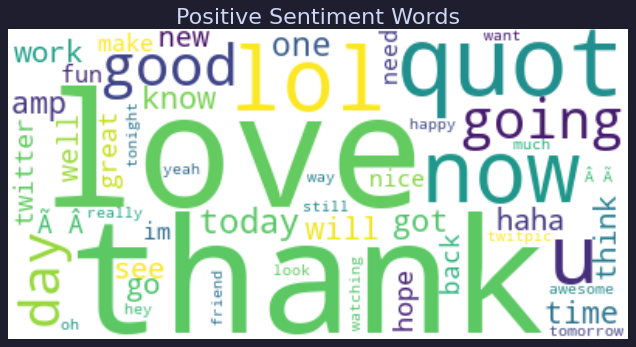

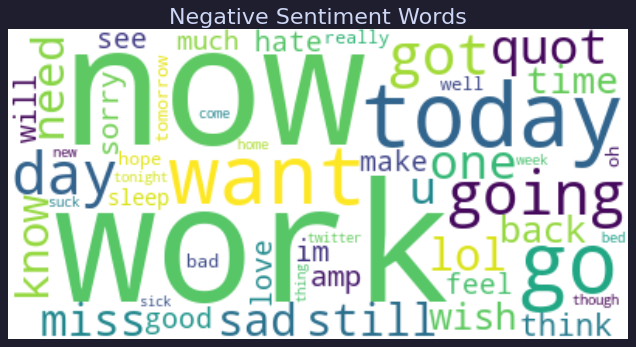

In [150]:
# Sentiment distribution
plot_sentiment_distribution(df)

# Pie chart of sentiments
fig = px.pie(df, names="sentiment", title="Sentiment Pie Chart")
fig.show()

summary_table = create_dataset_summary_table(train_ds, val_ds, test_ds)
console.print(summary_table)

# Tweet length distribution
plot_tweet_length_distribution(df)

# Positive tweet words
wordcount_gen(df, "Positive")
# Negative tweet words
wordcount_gen(df, "Negative")

## **3. Preprocessing and Vectorization**

In this section, we define several reusable functions to handle preprocessing and tokenization, preparing the dataset for subsequent processing. We opted for word-level tokenization to enable the model to better capture and learn the context within each sequence of words.

We aim to test two approaches, each designed to utilize a different type of embedding layer. Alongside preprocessing and tokenization, we also define functions to construct the initial layers of a reusable model, including the input layers up to the embedding layer. This modular approach, allows us to add deeper layers within the model in a later stage.

**`TextVectorizationLayer` and `Trainable` Embedding**

The first approach focuses on simplicity by applying basic preprocessing to the dataset, tailored specifically for a `TextVectorizationLayer`. This is achieved by implementing a straightforward standardization function, which the layer uses as its preprocessing logic. Due to the limitations of the `tf.strings` utility, which restricts the use of complex regex patterns, the preprocessing remains simple. This approach aims to remain general, so that it can be reused across various sentiment analysis classification tasks. On top of the `TextVectorizationLayer`, we also add an embedding layer that will be trained from scratch.

One key advantage of this first approach, beyond its simplicity, is that the vectorization logic is fully integrated within the model. This eliminates the need for separate preprocessing, as the entire pipeline is managed directly by the network.

**`Tokenizer` and `GloVe` Embedding**

One of the goals of this approach is to accelerate the training process at the embedding layer by leveraging pre-trained word vectors, unlike the first approach. Moreover, the preprocessing in this configuration is more specialized, designed specifically for Twitter messages, by utilizing complex regex patterns and a Keras `Tokenizer`.

A key distinction of this setup lies in the embedding layer. Here, we employ GloVe (https://nlp.stanford.edu/projects/glove/), specifically pre-trained word vectors trained on Twitter data (https://nlp.stanford.edu/data/glove.twitter.27B.zip). We eployed the 200-dimensional version.

The main advantage of this approach is its use of a pre-trained embedding layer, which reduces the need to learn word representations from scratch and allows to keep more focus on the deeper layers of the architecture. Additionally, this approach involves a more fine-grained preprocessing tailored specifically for Twitter messages, whereas the first approach is more generic. However, the dataset must go through a separate preprocessing, which is not seamlessly integrated within the network, unlike the previous approach.


In [178]:
####################################################################################
# First approach: `TextVectorization` layer with a trainable embedding
####################################################################################


# A more simple and generic preprocessing approach for sentiment analysis
def generic_preprocess(text):
    # Convert to lowercase
    text = tf.strings.lower(text)
    # Replace URLs with <url>
    text = tf.strings.regex_replace(text, r"http[s]?://\S+", "<url>")
    # Replace more than 1 dot (ellipsis) with <ellipsis>
    text = tf.strings.regex_replace(text, r"\.{2,}", "<ellipsis>")
    # Keep only relevant punctuation (!, ?, <ellipsis>)
    text = tf.strings.regex_replace(text, r"[^a-zA-Z0-9!?\.\s<ellipsis>]", "")
    # Strip leading/trailing whitespaces
    text = tf.strings.strip(text)

    return text


def create_vectorizer(max_tokens, max_seq_length, preprocess=generic_preprocess):
    vectorizer = layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode="int",
        output_sequence_length=max_seq_length,
        standardize=preprocess,
    )

    return vectorizer


# Build first layers of the model with a `TextVectorization` layer and a trainable embedding
def init_model_with_trainable_embedding(
    max_tokens, max_seq_length, embedding_dim, preprocess=generic_preprocess
):
    # Add the vectorization layer
    vectorization_layer = create_vectorizer(max_tokens, max_seq_length, preprocess)
    train_text = train_ds.map(lambda x, y: x)  # remove labels
    vectorization_layer.adapt(train_text)

    model = models.Sequential()

    model.add(vectorization_layer)

    # Add the Embedding layer
    model.add(layers.Embedding(input_dim=max_seq_length, output_dim=embedding_dim))

    return model

In [126]:
####################################################################################
# Second approach: `Tokenizer` and a pre-trained embedding layer (https://nlp.stanford.edu/projects/glove/)
####################################################################################


# Custom preprocessing for tweets, originally developed by Romain Paulus
# with minor modifications by Jeffrey Pennington. Initially implemented in Ruby,
# now adapted and refined for Python, with few changes. (https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb)
def preprocess_tweet(text):

    def handle_hashtag(match):
        hashtag = match.group(0)
        hashtag_body = hashtag[1:]
        if hashtag_body.isupper():
            return f"<HASHTAG> {hashtag_body} <ALLCAPS> "
        else:
            return "<HASHTAG> " + " ".join(re.split(r"(?=[A-Z])", hashtag_body))

    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    text = re.sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<URL> ", text)
    text = re.sub(r"/", " / ", text)
    text = re.sub(r"@\w+", "<USER> ", text)
    text = re.sub(rf"{eyes}{nose}[)d]+|[)d]+{nose}{eyes}", "<SMILE> ", text, flags=re.I)
    text = re.sub(rf"{eyes}{nose}p+", "<LOLFACE> ", text, flags=re.I)
    text = re.sub(rf"{eyes}{nose}\(+|\)+{nose}{eyes}", "<SADFACE> ", text)
    text = re.sub(rf"{eyes}{nose}[\/|l*]", "<NEUTRALFACE> ", text)
    text = re.sub(r"<3", "<HEART> ", text)
    text = re.sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<NUMBER> ", text)
    text = re.sub(r"#\S+", handle_hashtag, text)
    text = re.sub(r"([!?.]){2,}", lambda match: f"{match.group(1)} <REPEAT> ", text)
    text = re.sub(
        r"\b(\S*?)(.)\2{2,}\b",
        lambda match: f"{match.group(1)}{match.group(2)} <ELONG> ",
        text,
    )
    text = re.sub(r"[^a-zA-Z0-9!?\.\s<\>]", "", text)

    return text.lower()


# Preprocess dataset with the custom tweet preprocessing function
def preprocess_dataset(batched_ds):
    preprocessed_data = []
    labels = []

    for x, y in batched_ds.unbatch():
        preprocessed_data.append(preprocess_tweet(x.numpy().decode()))
        labels.append(y.numpy())

    preprocessed_data = np.array(preprocessed_data)
    labels = np.array(labels)

    return preprocessed_data, labels


# Load GloVe embedding
def load_glove_embedding(glove_file, embedding_dim):
    embeddings = {}
    with open(glove_file, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector
    return embeddings


# Create a GloVe embedding matrix
def create_embedding_matrix(word_index, embedding, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


# Preprocess the datasets.
# Build a `Tokenizer.
# Construct the tokenized sequences
def tokenize_datasets(train_ds, val_ds, test_ds, max_tokens, max_seq_length):
    # Preprocess datasets
    train_tweets, train_labels = preprocess_dataset(train_ds)
    val_tweets, val_labels = preprocess_dataset(val_ds)
    test_tweets, test_labels = preprocess_dataset(test_ds)

    # Create and fit tokenizer on the preprocessed training data
    tokenizer = preprocessing.text.Tokenizer(num_words=max_tokens, oov_token="<OOV>")
    tokenizer.fit_on_texts(train_tweets)

    # Convert data sets to padded sequences
    train_tweets = preprocessing.sequence.pad_sequences(
        tokenizer.texts_to_sequences(train_tweets),
        maxlen=max_seq_length,
        padding="post",
    )
    val_tweets = preprocessing.sequence.pad_sequences(
        tokenizer.texts_to_sequences(val_tweets),
        maxlen=max_seq_length,
        padding="post",
    )
    test_tweets = preprocessing.sequence.pad_sequences(
        tokenizer.texts_to_sequences(test_tweets),
        maxlen=max_seq_length,
        padding="post",
    )

    return (
        tokenizer,
        train_tweets,
        train_labels,
        val_tweets,
        val_labels,
        test_tweets,
        test_labels,
    )


# Builds the GloVe embedding matrix
def build_glove_matrix(glove_file, embedding_dim, word_index):

    # GloVe embedding
    glove_embedding = load_glove_embedding(glove_file, embedding_dim)
    embedding_matrix = create_embedding_matrix(
        word_index, glove_embedding, embedding_dim
    )

    return embedding_matrix


# Build the initial layers of the model with GloVe embedding
def init_model_with_glove_embedding(
    max_seq_length, vocab_size, embedding_dim, embedding_matrix
):

    model = models.Sequential()

    model.add(layers.Input(shape=(max_seq_length,)))
    # Add the pre-trained GloVe embedding
    model.add(
        layers.Embedding(
            vocab_size,
            embedding_dim,
            weights=[embedding_matrix],
            trainable=False,
        )
    )

    return model

## **4. Naive Bayes for text classification**

To establish a solid baseline for comparing the performance of our final model, we use Naive Bayes as our classifier for the sentiment analysis task. Naive Bayes is a simple yet effective probabilistic model that we use for benchmarking due to its efficiency and ease of implementation. By comparing the results from Naive Bayes with those of our final model, we can draw meaningful conclusions about the effectiveness, improvements and trade-offs of our final model.


In [127]:
## Naive Bayes used as a benchmarking model, for comparison with the final model

# Convert datasets for the model pipeline
X_train, y_train = unbatch_ds(train_ds, decode=True, np_array=True)
X_val, y_val = unbatch_ds(val_ds, decode=True, np_array=True)
X_test, y_test = unbatch_ds(test_ds, decode=True, np_array=True)

# Since we are using the model as a simple benchmark, we keep things simple and combine the validation and test sets for the evaluation
X_test = np.concatenate([X_val, X_test])
y_test = np.concatenate([y_val, y_test])

# Preprocess the datasets
preprocess = np.vectorize(preprocess_tweet)
X_train = preprocess(X_train)
X_test = preprocess(X_test)

# Initialize the model pipeline
vectorizer = CountVectorizer(max_features=2000)
model = pipeline.make_pipeline(vectorizer, naive_bayes.MultinomialNB())

# Fit the model
model.fit(X_train, y_train)

# Evaluate the model
preds = model.predict(X_test)
evaluation_table = model_evaluation_table("Naive Bayes", preds, y_test)
console.print(evaluation_table)

2024-12-31 16:23:41.718096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-31 16:23:43.068414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-31 16:23:44.347095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Evaluation Results for
     Naive Bayes      
┏━━━━━━━━━━━┳━━━━━━━━┓
┃  Metric   ┃ Result ┃
┡━━━━━━━━━━━╇━━━━━━━━┩
│ Accuracy  │ 0.7712 │
├───────────┼────────┤
│ Precision │ 0.7735 │
├───────────┼────────┤
│  Recall   │ 0.7683 │
├───────────┼────────┤
│ F1-Score  │ 0.7709 │
└───────────┴────────┘

## **5. A Bidirectional LSTM based Model**

In this section, we will extend a model to complete the construction of an LSTM-based architecture capable of capturing the structure and context of messages for sentiment analysis. Both model configurations developed earlier will be extended. We will design a deep architecture that combines multiple Bidirectional LSTM layers with Dense layers, incorporating techniques to avoid overfitting.

The idea behind the architecture is pretty simple: focus on capturing detailed information in the earlier layers of the network and then gradually reduce the complexity as we go deeper. This way, the model starts by learning fine-grained patterns and then refines them into more abstract representations as the layers progress.

**2 Bidirectional LSTM Layers**

The first two layers of the architecture (excluding the already built "input" layers) are Bidirectional LSTM layers. These layers are crucial for capturing the context of messages by processing the input sequence both forward and backward, providing a comprehensive understanding of the text.

To better capture sequential information, we set both layers to return sequences. This means that instead of outputting just the final hidden state of LSTM, the layers return a hidden state for every time step in the input sequence. This allows subsequent layers to have access to the complete sequence of hidden states, preserving information from every part of the input.

In line with our approach, the second LSTM layer is designed with half the number of units compared to the first one. This follows our strategy of reducing complexity as the architecture deepens. Additionally, we apply dropout to the input units of the LSTM layers to prevent overfitting and improve the model’s ability to generalize.

**Pooling**

To summarize the sequence information into a fixed-size representation by averaging across time steps, we used a `GlobalAveragePooling1D()` layer. Its goal is to reduce the sequence dimension by calculating the average of the hidden states across all time steps. It provides a compact representation, suitable for downstream layers in the architecture.

**Dense Layers**

For the deeper layers, we use four Dense layers to progressively abstract the features learned by the previous layers. The number of units is halved with each successive layer to reduce complexity, eventually reaching the final output layer (with a single unit) for the binary classification task.

**Dropout Layers**

To improve generalization, we apply dropout layers between each Dense layer. This should help to prevent overfitting by randomly disabling a fraction of the units during training.

**Tuning Wrapper**

To optimize some of the model's hyperparameters, we use a random search strategy with `KerasTuner`. To streamline the tuning process, we’ve built a wrapper around the `RandomSearch` tuner. This wrapper simplifies the process of hyperparameter tuning, enabling us to efficiently train and evaluate the best resulting model.


In [174]:
DEFAULT_EPOCHS = 20
DEFAULT_PATIENCE = 4
DEFAULT_BATCH_SIZE = 32
DEFAULT_MAX_TRIALS = 15
DEFAULT_SEED = 42


# Build a deep architecture based on LSTM, extending an already initialized model (e.g. with TextVectorization and Embedding Layers)
def extend_model(model, hp):

    # Tune the units and dropout rate of LSTM layers
    lstm_units = hp.Int("lstm_units", min_value=128, max_value=256, step=32)
    dropout_lstm = hp.Float("dropout_lstm", min_value=0.2, max_value=0.4, step=0.05)

    model.add(
        layers.Bidirectional(
            layers.LSTM(units=lstm_units, return_sequences=True, dropout=dropout_lstm)
        )
    )
    model.add(
        layers.Bidirectional(
            layers.LSTM(
                units=lstm_units // 2, return_sequences=True, dropout=dropout_lstm
            )
        )
    )
    # Global average pooling to summarize the sequence data
    model.add(layers.GlobalAveragePooling1D())

    # Units of the first Dense layer
    init_dense_units = lstm_units // 2

    # Tune the dropout rate of Dropout layers
    dropout_dense = hp.Float("dropout_dense", min_value=0.2, max_value=0.4, step=0.05)

    # Add Dense layers interleaved with dropout layers
    model.add(layers.Dense(init_dense_units, activation="relu"))
    model.add(layers.Dropout(dropout_dense))
    model.add(layers.Dense(init_dense_units // 2, activation="relu"))
    model.add(layers.Dropout(dropout_dense))
    model.add(layers.Dense(init_dense_units // 4, activation="relu"))
    model.add(layers.Dropout(dropout_dense))

    # Output layer
    model.add(layers.Dense(1, activation="sigmoid"))

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )


# Tuner for the LSTM based model
# It uses a `RandomSearch` tuner to find the optimal hyperparameters.
# It also trains and evaluates the best resulting model
class SentymentAnalysisTuner:
    def __init__(
        self,
        build,
        model_name,
        dir,
        project_name,
        objective="val_accuracy",
        max_trials=DEFAULT_MAX_TRIALS,
        overwrite=True,
        seed=DEFAULT_SEED,
        debug=False,
    ):
        self.build = build
        self.model_name = model_name
        self.dir = dir
        self.project_name = project_name
        self.objective = objective
        self.max_trials = max_trials
        self.overwrite = overwrite
        self.seed = seed
        self.debug = debug

        self.tuner = None
        self.best_model = None
        self.history = None

    # Performs a random search to find the best hyperparameters for the model
    def search(
        self,
        train_ds,
        val_ds,
        epochs=DEFAULT_EPOCHS,
        patience=DEFAULT_PATIENCE,
        batch_size=DEFAULT_BATCH_SIZE,
    ):
        # Tuner configuration for optimal hyperparameters
        self.tuner = kt.RandomSearch(
            self.build,
            objective=self.objective,
            max_trials=self.max_trials,
            overwrite=self.overwrite,
            directory=self.dir,
            project_name=self.project_name,
            seed=self.seed,
        )

        if isinstance(train_ds, tuple):
            train_data = train_ds[0]
            train_labels = train_ds[1]

            self.tuner.search(
                train_data,
                train_labels,
                validation_data=val_ds,
                verbose=self.debug,
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[callbacks.EarlyStopping(patience=patience)],
            )
        else:
            self.tuner.search(
                train_ds,
                validation_data=val_ds,
                verbose=self.debug,
                epochs=epochs,
                callbacks=[callbacks.EarlyStopping(patience=patience)],
            )

    def get_best_hyperparameters(self, num_trials=1):
        if self.tuner is None:
            raise ValueError("Model has not been tuned yet.")

        return self.tuner.get_best_hyperparameters(num_trials=num_trials)[0]

    # Train the model with the best hyperparameters
    def fit(
        self,
        train_ds,
        val_ds,
        epochs=DEFAULT_EPOCHS,
        patience=DEFAULT_PATIENCE,
        batch_size=DEFAULT_BATCH_SIZE,
    ):
        if self.tuner is None:
            raise ValueError("Model has not been tuned yet.")

        best_hp = self.get_best_hyperparameters()
        best_model = self.tuner.hypermodel.build(best_hp)

        if isinstance(train_ds, tuple):
            train_data = train_ds[0]
            train_labels = train_ds[1]

            history = best_model.fit(
                train_data,
                train_labels,
                validation_data=val_ds,
                verbose=self.debug,
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[callbacks.EarlyStopping(patience=patience)],
            )

            self.history = history

        else:
            history = best_model.fit(
                train_ds,
                validation_data=val_ds,
                verbose=self.debug,
                epochs=epochs,
                callbacks=[callbacks.EarlyStopping(patience=patience)],
            )

            self.history = history

        self.best_model = best_model

    # Shows the best model infotmation: hyperparameters, architecture, and training history
    def show_model(self):
        if self.best_model is None:
            raise ValueError("Best model has not been trained yet.")

        # Print best hyperparameters
        best_hp = self.get_best_hyperparameters()
        best_hp_table = best_hyperparameters_table(best_hp, self.model_name)
        console.print(best_hp_table)

        # Plot model architecture
        tf.keras.utils.plot_model(self.best_model, show_shapes=True)

        # Plot training history
        plot_training_history(self.history)

    # Evaluate the resulting model and print the results
    def evaluate_and_print_results(self, test_data, test_labels):
        if self.best_model is None:
            raise ValueError("Best model has not been trained yet.")

        # Evaluate the model
        preds = self.best_model.predict(test_data)
        # Round predictions to 0 or 1
        preds = (preds > 0.5).astype(int)

        eval_table = model_evaluation_table(self.model_name, preds, test_labels)
        console.print(eval_table)

In [179]:
MODEL_NAME = "Bidirectional LSTM with Trainable Embedding"
TUNING_DIR = "Tuning_1"

# ---------------------------------------------------
# Configuration

# Vocabulary size
MAX_TOKENS = 10000
# Maximum sequence length
MAX_SEQUENCE_LENGTH = 50
# Embedding dimension
EMBEDDING_DIM = 256
# ---------------------------------------------------


def build_model_with_trainable_embedding(hp):
    # Initialize the model with trainable embedding
    model_with_trainable_emb = init_model_with_trainable_embedding(
        max_tokens=MAX_TOKENS,
        max_seq_length=MAX_SEQUENCE_LENGTH,
        embedding_dim=EMBEDDING_DIM,
    )
    # Extend the initialized model
    extend_model(model_with_trainable_emb, hp)

    return model_with_trainable_emb


# Initialize the tuner and start the search
tuner_t_emb = SentymentAnalysisTuner(
    build=build_model_with_trainable_embedding,
    model_name=MODEL_NAME,
    dir=TUNING_DIR,
    project_name="tuner_lstm_trainable_embedding",
    debug=DEBUG,
)
tuner_t_emb.search(train_ds, val_ds)

# Train the model with the best hyperparameters
tuner_t_emb.fit(train_ds, val_ds)

# Show the model's information
tuner_t_emb.show_model()

# Evaluate the resulting model and print results
X_test, y_test = unbatch_ds(test_ds)
tuner_t_emb.evaluate_and_print_results(X_test, y_test)

2024-12-31 01:31:47.028942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
224               |224               |lstm_units
0.2               |0.2               |dropout_lstm
0.3               |0.3               |dropout_dense

Epoch 1/20


2024-12-31 01:32:09.375503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 631/3281 ━━━━━━━━━━━━━━━━━━━━ 7:49 177ms/step - accuracy: 0.4987 - loss: 0.9415

KeyboardInterrupt: 

In [180]:
MODEL_NAME = "Bidirectional LSTM with GloVe Embedding"
TUNING_DIR = "Tuning_2"

GLOVE_FILE = "../GloVe/glove.twitter.27B.200d.txt"

# ---------------------------------------------------
# Configuration

# Vocabulary size
MAX_TOKENS = 10000
# Maximum sequence length
MAX_SEQUENCE_LENGTH = 50
# Embedding dimension
EMBEDDING_DIM = 200
# ---------------------------------------------------

# Preprocessing
(
    tokenizer,
    train_tweets,
    train_labels,
    val_tweets,
    val_labels,
    test_tweets,
    test_labels,
) = tokenize_datasets(
    train_ds, val_ds, test_ds, max_tokens=MAX_TOKENS, max_seq_length=MAX_SEQUENCE_LENGTH
)
# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1
# GloVe embedding matrix
embedding_matrix = build_glove_matrix(GLOVE_FILE, EMBEDDING_DIM, tokenizer.word_index)


def build_model_with_glove_embedding(hp):
    # Initialize the model with GloVe embedding
    model_with_glove_emb = init_model_with_glove_embedding(
        max_seq_length=MAX_SEQUENCE_LENGTH,
        vocab_size=vocab_size,
        embedding_dim=EMBEDDING_DIM,
        embedding_matrix=embedding_matrix,
    )
    # Extend the initialized model
    extend_model(model_with_glove_emb, hp)

    return model_with_glove_emb


# Initialize the tuner and start the search
tuner_glove = SentymentAnalysisTuner(
    build=build_model_with_glove_embedding,
    model_name=MODEL_NAME,
    dir=TUNING_DIR,
    project_name="tuner_lstm_glove_embedding",
    debug=DEBUG,
)
tuner_glove.search(
    train_ds=(train_tweets, train_labels), val_ds=(val_tweets, val_labels)
)

# Train the model with the best hyperparameters
tuner_glove.fit(train_ds=(train_tweets, train_labels), val_ds=(val_tweets, val_labels))

# Show the model's information
tuner_glove.show_model()

# Evaluate the resulting model and print results
tuner_glove.evaluate_and_print_results(test_tweets, test_labels)

2024-12-31 01:34:21.455544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-31 01:34:23.499425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-31 01:34:25.481552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
224               |224               |lstm_units
0.2               |0.2               |dropout_lstm
0.3               |0.3               |dropout_dense

Epoch 1/20
  15/3281 ━━━━━━━━━━━━━━━━━━━━ 8:58 165ms/step - accuracy: 0.5247 - loss: 0.7293

KeyboardInterrupt: 

## **6. Conclusions**

**7. Simple Test with our own Tweets**


In [ ]:
# Our own tweets
positive_tweets = [
    "Had a great time coding today! #coding #ML",
    "Just finished a workout, feeling strong 💪 #fitness",
    "Love this new song, I reccomaned it to everyone! 🎵 #music",
    "Just got the best coffee in town ☕ #coffee #morning",
    "Watching the game tonight, LETS GOOO TEAM!! 🏀 #sports",
]

negative_tweets = [
    "I am so tired of coding, nothing seems to work! 😩 #frustrated",
    "My workout was awful today, couldn't even finish. 😔 #fitnessfail",
    "This song is terrible, why is it so popular? 😤 #musicdislike",
    "The coffee I got was horrible, it tasted burnt. 😒 #coffeeproblem",
    "The game was so boring, I almost fell asleep. 😴 #sportsfail",
]

# Combine positive and negative tweets
tweets = positive_tweets + negative_tweets
labels = [1] * len(positive_tweets) + [0] * len(negative_tweets)

# Combine tweets into one list
tweets = positive_tweets + negative_tweets

# Convert the raw tweets and labels into a TensorFlow dataset
personal_test_tweets = tf.constant(tweets)
personal_test_labels = tf.constant(labels)

# Create the test dataset
personal_test_ds = tf.data.Dataset.from_tensor_slices(
    (personal_test_tweets, personal_test_labels)
)
personal_test_ds = personal_test_ds.batch(1)

personal_test_tweets, personal_test_labels = preprocess_dataset(personal_test_ds)
personal_test_tweets = preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(personal_test_tweets),
    maxlen=MAX_SEQUENCE_LENGTH,
    padding="post",
)

# Evaluate the final model with GloVe embeddings on our own tweets
tuner_glove.evaluate_and_print_results(personal_test_tweets, personal_test_labels)